## Step 1: Upload the A/B test results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm

# Load dataset 
df = pd.read_csv("Interim Analysis.csv")

df = df.rename(columns={
    "Days to Respond": "Days",
    "Response Rate": "Cumulative Response Rate"
})

# Ensure groups and sorting are correct
df = df.sort_values(["Days", "Group"])

print(df)

     Days    Group  Responses   Leads  Cumulative Response Rate
57      1  Control          0  115528                  0.000000
0       1     Test          0  115528                  0.000000
58      2  Control          0  115528                  0.000000
1       2     Test          0  115528                  0.000000
59      3  Control          0  115528                  0.000000
..    ...      ...        ...     ...                       ...
54     55     Test        434  115528                  0.003757
112    56  Control        419  115528                  0.003627
55     56     Test        451  115528                  0.003904
113    57  Control        430  115528                  0.003722
56     57     Test        456  115528                  0.003947

[114 rows x 5 columns]


## Step 2: Compute the alpha spending threshold for each interim look

In [2]:
# Two functions are used: O'Brien-Fleming & Pocock alpha spending functions

def obrien_fleming_alpha(look_number, total_looks, final_alpha=0.05):
    information_fraction = look_number / total_looks
    boundary = norm.ppf(1 - final_alpha / 2) / np.sqrt(information_fraction)
    interim_alpha = 2 * (1 - norm.cdf(boundary))
    return interim_alpha


def pocock_alpha(look_number, total_looks, final_alpha=0.05):
    # Pocock critical value
    pocock_boundary = norm.ppf(1 - final_alpha / (2 * np.log(total_looks + 1)))
    interim_alpha = 2 * (1 - norm.cdf(pocock_boundary))
    return interim_alpha

In [3]:
# Interim analysis with rate stabilization and zero handling

unique_days = sorted(df["Days"].unique())
total_looks = len(unique_days)

results = []

eps = 1e-9  # To avoid 0 or 1 probabilities

for i, day in enumerate(unique_days, start=1):
    d = df[df["Days"] == day]

    # Extract rows
    test_row = d[d["Group"] == "Test"].iloc[0]
    ctrl_row = d[d["Group"] == "Control"].iloc[0]

    # Original rates
    test_rate = test_row["Cumulative Response Rate"]
    ctrl_rate = ctrl_row["Cumulative Response Rate"]

    # Adjust rates to avoid exactly 0 or 1
    test_rate_adj = np.clip(test_rate, eps, 1 - eps)
    ctrl_rate_adj = np.clip(ctrl_rate, eps, 1 - eps)

    # Sample sizes
    n_test = test_row["Leads"]
    n_ctrl = ctrl_row["Leads"]

    # Calculate responder counts
    x_test = test_rate_adj * n_test
    x_ctrl = ctrl_rate_adj * n_ctrl

    # Hypothesis test
    if n_test == 0 or n_ctrl == 0:
        z_stat = np.nan
        pval = np.nan
    else:
        z_stat, pval = proportions_ztest(
            count=[x_test, x_ctrl],
            nobs=[n_test, n_ctrl],
            alternative="two-sided"
        )

    # Two alpha-spending thresholds
    obf_alpha = obrien_fleming_alpha(i, total_looks, final_alpha=0.05)
    pocock_alpha_value = pocock_alpha(i, total_looks, final_alpha=0.05)

    results.append({
        "Day": day,
        "Test Response Rate": test_rate,
        "Control Response Rate": ctrl_rate,
        "Incremental Lift in Response Rate": test_rate - ctrl_rate,
        "z Stat": z_stat,
        "p Value": pval,
        "Alpha (0.05)": 0.05,
        "OBF Alpha": obf_alpha,
        "Pocock Alpha": pocock_alpha_value,
        "OBF Significant": (pval < obf_alpha) if not np.isnan(pval) else False,
        "Pocock Significant": (pval < pocock_alpha_value) if not np.isnan(pval) else False,
        "Significant (Alpha = 0.05)": (pval < 0.05) if not np.isnan(pval) else False
    })

In [4]:
# Print the results
results_df = pd.DataFrame(results)
print("\nInterim Analysis Results:")
print(results_df.head())


Interim Analysis Results:
   Day  Test Response Rate  Control Response Rate  \
0    1                 0.0                    0.0   
1    2                 0.0                    0.0   
2    3                 0.0                    0.0   
3    4                 0.0                    0.0   
4    5                 0.0                    0.0   

   Incremental Lift in Response Rate  z Stat  p Value  Alpha (0.05)  \
0                                0.0     0.0      1.0          0.05   
1                                0.0     0.0      1.0          0.05   
2                                0.0     0.0      1.0          0.05   
3                                0.0     0.0      1.0          0.05   
4                                0.0     0.0      1.0          0.05   

      OBF Alpha  Pocock Alpha  OBF Significant  Pocock Significant  \
0  0.000000e+00      0.012314            False               False   
1  0.000000e+00      0.012314            False               False   
2  0.000000e+00  

In [5]:
# Save results to Excel
results_df.to_excel("Interim Analysis Results.xlsx", index=False)

print("\nExcel file saved: Interim Analysis Results.xlsx")


Excel file saved: Interim Analysis Results.xlsx


## Step 3: Determine the statistical significance (normal approach vs alpha spending approaches)

In [6]:
# Create a colour palette
blue = "#0033A0"
gold = "#FFB81C"
light_blue = "#6CCFF6"
gray = "#A2AAAD"

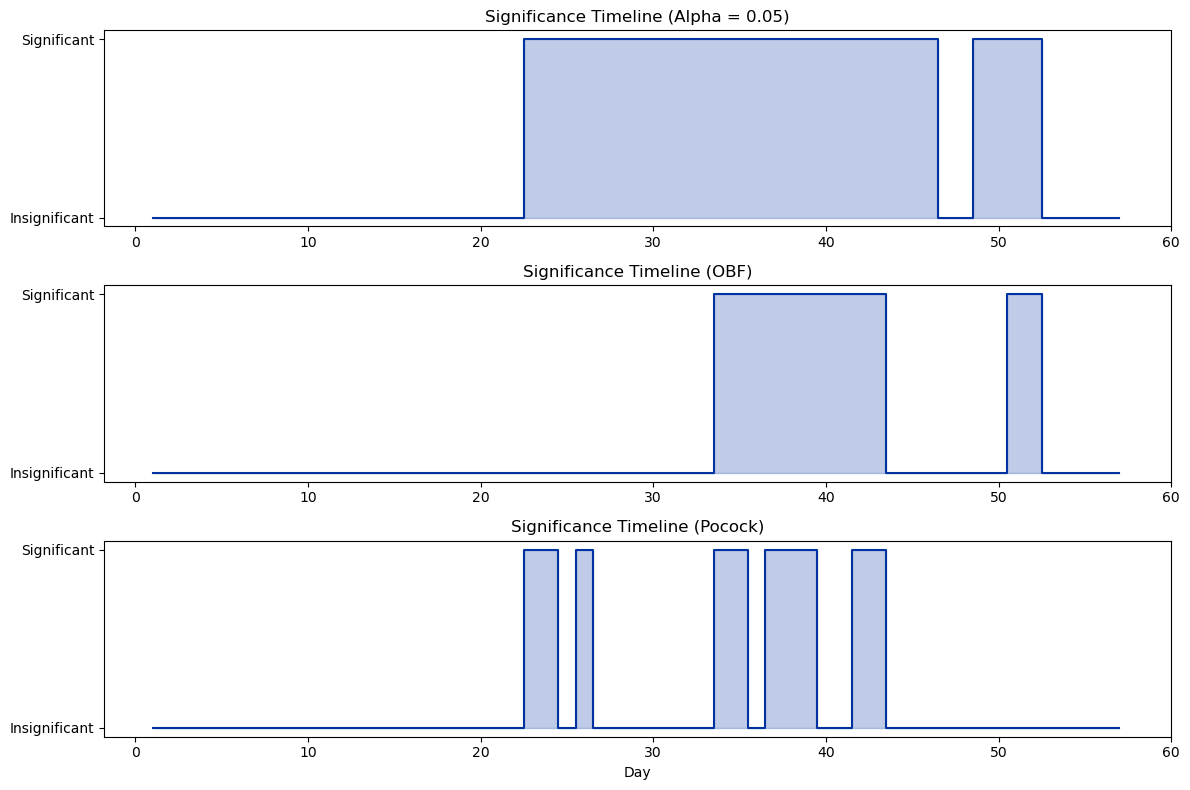

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Predefine x-values
x = results_df["Day"]

# ============ Chart 1: Alpha = 0.05 ===============
y_p05 = (results_df["p Value"] < 0.05)

axes[0].plot(x, y_p05, drawstyle="steps-mid", color=blue, label="Alpha = 0.05 Significant")
axes[0].fill_between(x, 0, y_p05, step="mid", alpha=0.25, color=blue)  # shading here

axes[0].set_title("Significance Timeline (Alpha = 0.05)")
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(["Insignificant", "Significant"])
axes[0].set_xticks([0, 10, 20, 30, 40, 50, 60])
axes[0].tick_params(labelbottom=True)

# ============ Chart 2: OBF ===============
y_obf = results_df["OBF Significant"]

axes[1].plot(x, y_obf, drawstyle="steps-mid", color=blue, label="OBF Significant")
axes[1].fill_between(x, 0, y_obf, step="mid", alpha=0.25, color=blue)  # shading here

axes[1].set_title("Significance Timeline (OBF)")
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(["Insignificant", "Significant"])
axes[1].set_xticks([0, 10, 20, 30, 40, 50, 60])
axes[1].tick_params(labelbottom=True)

# ============ Chart 3: Pocock ===============
y_poc = results_df["Pocock Significant"]

axes[2].plot(x, y_poc, drawstyle="steps-mid", color=blue, label="Pocock Significant")
axes[2].fill_between(x, 0, y_poc, step="mid", alpha=0.25, color=blue)  # shading here

axes[2].set_title("Significance Timeline (Pocock)")
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(["Insignificant", "Significant"])
axes[2].set_xticks([0, 10, 20, 30, 40, 50, 60])
axes[2].set_xlabel("Day")
axes[2].tick_params(labelbottom=True)

plt.tight_layout()
plt.show()

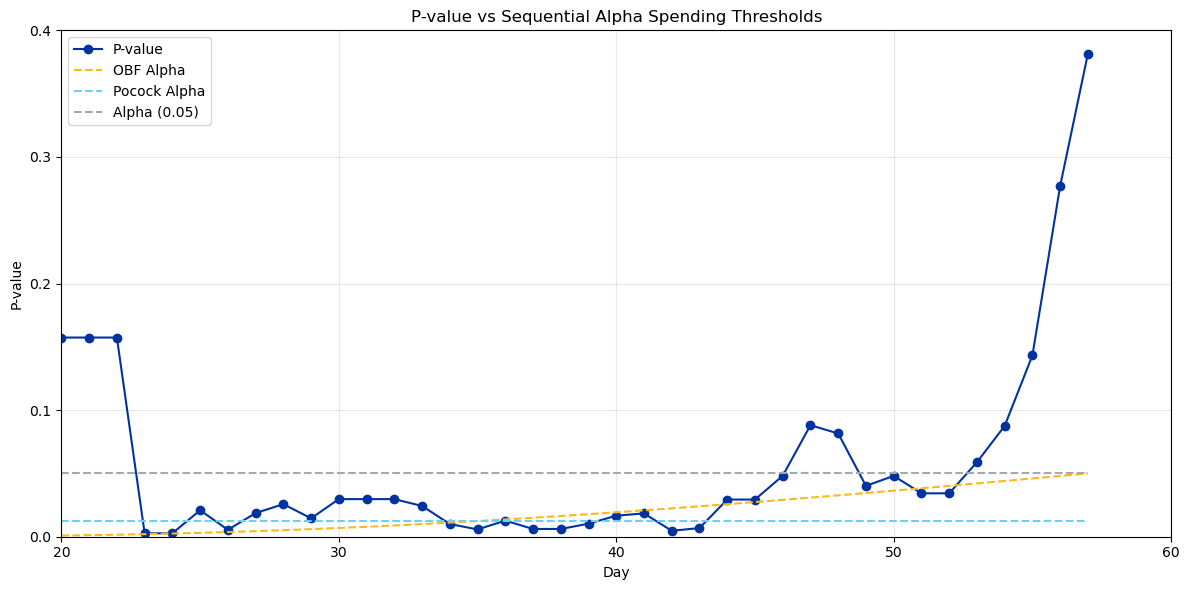

In [8]:
# Keep only Day ≥ 20
plot_df = results_df[results_df["Day"] >= 20]

plt.figure(figsize=(12,6))

# Use filtered dataframe for all plotted lines
plt.plot(plot_df["Day"], plot_df["p Value"], marker="o", color=blue, label="P-value")
plt.plot(plot_df["Day"], plot_df["OBF Alpha"], linestyle="--", color=gold, label="OBF Alpha")
plt.plot(plot_df["Day"], plot_df["Pocock Alpha"], linestyle="--", color=light_blue, label="Pocock Alpha")
plt.plot(plot_df["Day"], plot_df["Alpha (0.05)"], linestyle="--", color=gray, label="Alpha (0.05)")

# Set axis ranges
plt.ylim(0, 0.4)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4])

plt.xlim(20, 60)
plt.xticks([20, 30, 40, 50, 60])

plt.xlabel("Day")
plt.ylabel("P-value")
plt.title("P-value vs Sequential Alpha Spending Thresholds")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

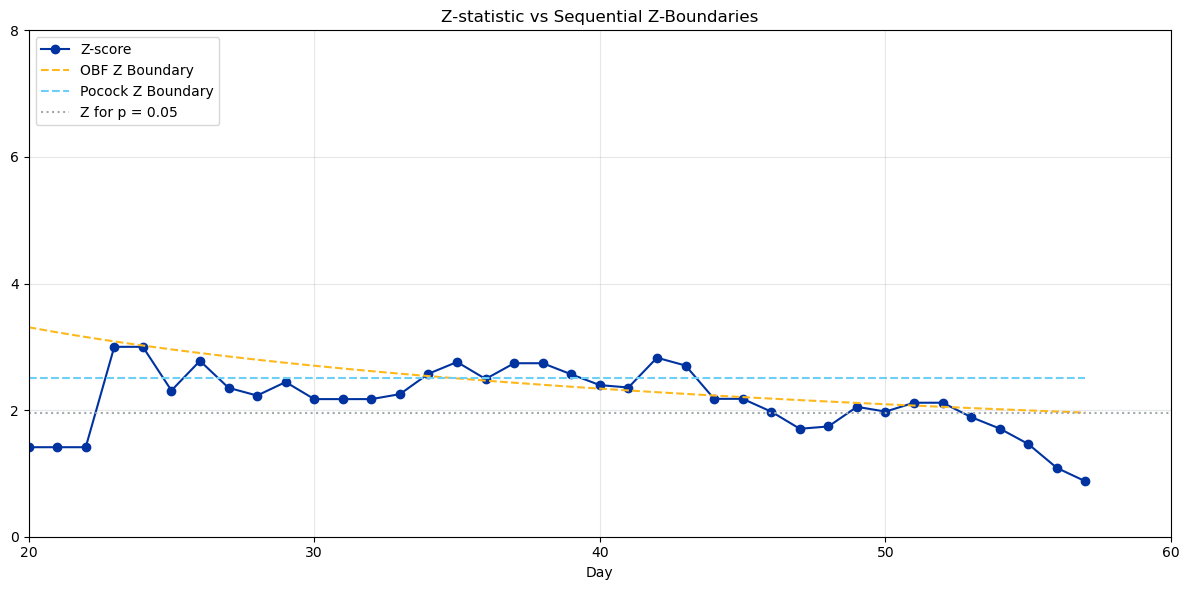

In [9]:
# Compute Z-boundaries
results_df["OBF Z Boundary"] = norm.ppf(1 - results_df["OBF Alpha"] / 2)
results_df["Pocock Z Boundary"] = norm.ppf(1 - results_df["Pocock Alpha"] / 2)

# Keep only Day ≥ 20
plot_df = results_df[results_df["Day"] >= 20]

plt.figure(figsize=(12,6))

# Use filtered dataframe for all plotted lines
plt.plot(plot_df["Day"], plot_df["z Stat"], marker="o", color=blue, label="Z-score")
plt.plot(plot_df["Day"], plot_df["OBF Z Boundary"], linestyle="--", color=gold, label="OBF Z Boundary")
plt.plot(plot_df["Day"], plot_df["Pocock Z Boundary"], linestyle="--", color=light_blue, label="Pocock Z Boundary")
plt.axhline(norm.ppf(1 - 0.05/2), color=gray, linestyle=":", label="Z for p = 0.05")

# Axis range and ticks
plt.xlim(20, 60)
plt.xticks(range(20, 61, 10))

plt.ylim(0, 8)
plt.yticks(range(0, 9, 2))

plt.xlabel("Day")
plt.title("Z-statistic vs Sequential Z-Boundaries")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

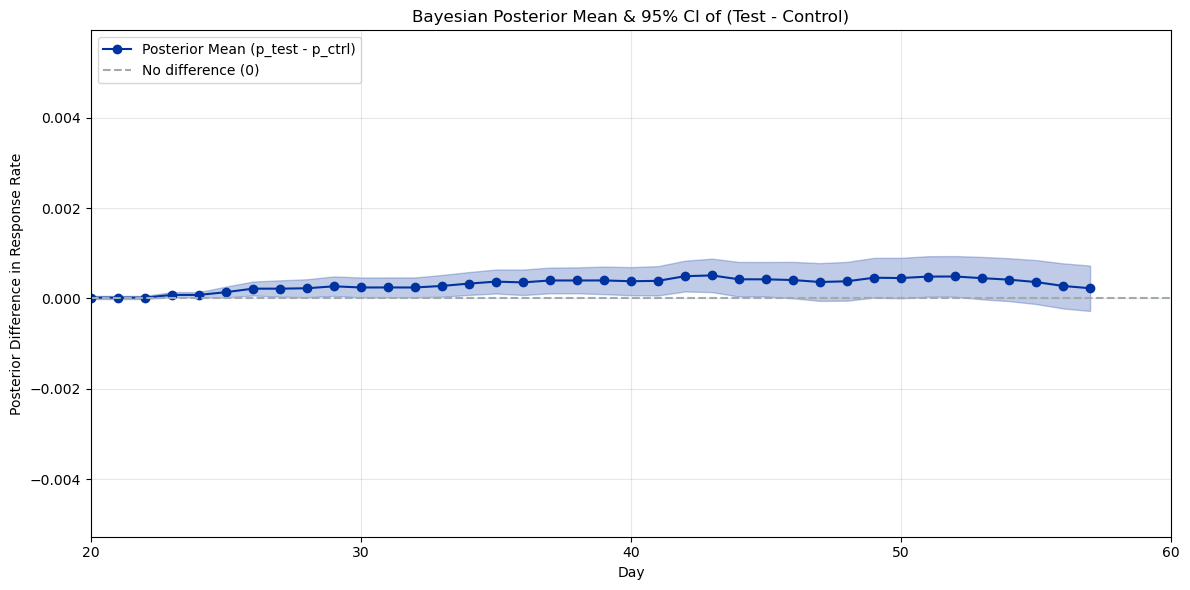

In [10]:
# Posterior Mean Difference with 95% CI
prior_a = 1    # Beta(a,b) prior (a)
prior_b = 1    # Beta(a,b) prior (b)
posterior_samples = 100000   

day_col = "Days"
group_col = "Group"
rate_col = "Cumulative Response Rate"
leads_col = "Leads"

# Build a list of unique days in sorted order
unique_days = sorted(df[day_col].unique())

# Prepare results container
bayes_rows = []

for day in unique_days:
    d = df[df[day_col] == day]
    # extract test and control rows
    test_row = d[d[group_col] == "Test"].iloc[0]
    ctrl_row = d[d[group_col] == "Control"].iloc[0]

    # raw rates and leads
    p_test = float(test_row[rate_col])
    p_ctrl = float(ctrl_row[rate_col])
    n_test = int(test_row[leads_col])
    n_ctrl = int(ctrl_row[leads_col])

    # Convert rates to responder counts (round to nearest integer)
    x_test = int(round(p_test * n_test))
    x_ctrl = int(round(p_ctrl * n_ctrl))

    # Posterior parameters for Beta posterior: Beta(a + x, b + n - x)
    a_test = prior_a + x_test
    b_test = prior_b + (n_test - x_test)
    a_ctrl = prior_a + x_ctrl
    b_ctrl = prior_b + (n_ctrl - x_ctrl)

    # draw posterior samples
    p_test_samps = np.random.beta(a_test, b_test, size=posterior_samples)
    p_ctrl_samps = np.random.beta(a_ctrl, b_ctrl, size=posterior_samples)

    # posterior of difference
    diff_samps = p_test_samps - p_ctrl_samps

    # summary stats
    diff_mean = diff_samps.mean()
    ci_lower = np.percentile(diff_samps, 2.5)
    ci_upper = np.percentile(diff_samps, 97.5)
    prob_test_better = (diff_samps > 0).mean()   # P(Test > Control)

    # store results
    bayes_rows.append({
        "Day": day,
        "n_test": n_test,
        "n_ctrl": n_ctrl,
        "x_test": x_test,
        "x_ctrl": x_ctrl,
        "Posterior Mean Diff": diff_mean,
        "CI Lower (2.5%)": ci_lower,
        "CI Upper (97.5%)": ci_upper,
        "P(Test > Control)": prob_test_better
    })

bayes_df = pd.DataFrame(bayes_rows).sort_values("Day").reset_index(drop=True)

# Keep only Day ≥ 20
plot_df = bayes_df[bayes_df["Day"] >= 20]
plt.figure(figsize=(12,6))

# Use plot_df instead of bayes_df
plt.plot(
    plot_df["Day"],
    plot_df["Posterior Mean Diff"],
    marker="o",
    color=blue,
    label="Posterior Mean (p_test - p_ctrl)"
)

plt.fill_between(
    plot_df["Day"],
    plot_df["CI Lower (2.5%)"],
    plot_df["CI Upper (97.5%)"],
    alpha=0.25,
    color=blue
)

# horizontal zero line
plt.axhline(0, color=gray, linestyle="--", label="No difference (0)")

# axes formatting (starting at Day 20)
plt.xlim(20, 60)
plt.xticks(range(20, 61, 10))

# y-axis padding
plt.ylim(
    plot_df["CI Lower (2.5%)"].min() - 0.005,
    plot_df["CI Upper (97.5%)"].max() + 0.005
)

plt.xlabel("Day")
plt.ylabel("Posterior Difference in Response Rate")
plt.title("Bayesian Posterior Mean & 95% CI of (Test - Control)")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

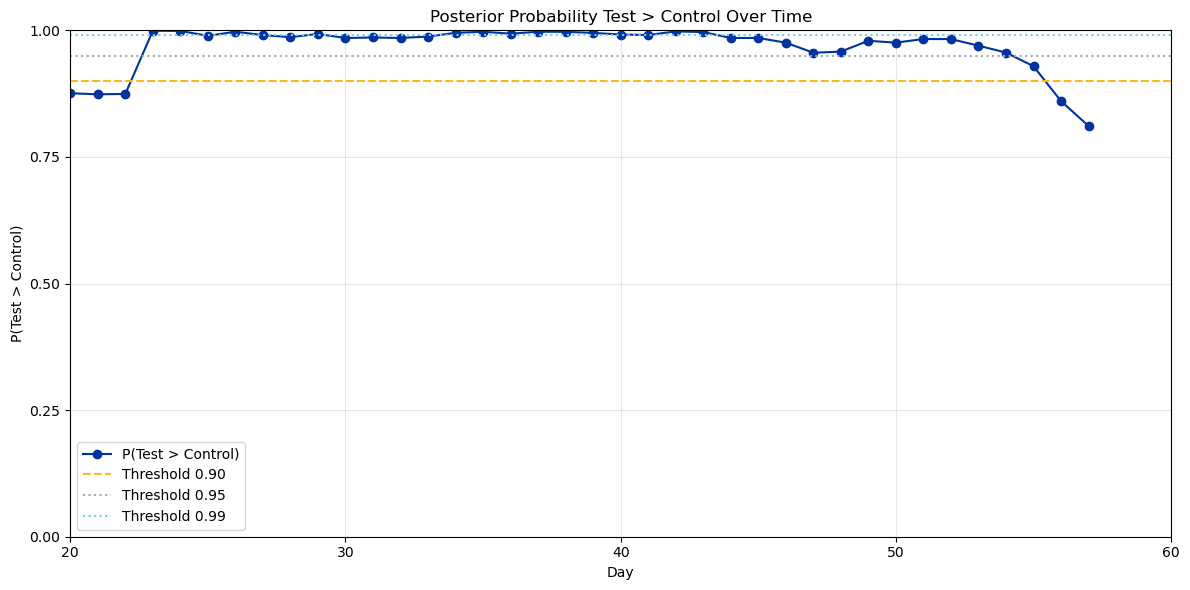

In [11]:
# Posterior Probability P(Test > Control) 
plot_df = bayes_df[bayes_df["Day"] >= 20]

plt.figure(figsize=(12,6))

plt.plot(
    plot_df["Day"],
    plot_df["P(Test > Control)"],
    marker="o",
    color=blue,
    label="P(Test > Control)"
)

# Decision thresholds
plt.axhline(0.90, color=gold, linestyle="--", label="Threshold 0.90")
plt.axhline(0.95, color=gray, linestyle=":", label="Threshold 0.95")
plt.axhline(0.99, color=light_blue, linestyle=":", label="Threshold 0.99")

# X-axis
plt.xlim(20, 60)
plt.xticks(range(20, 61, 10))

# Y-axis
plt.ylim(0, 1)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.xlabel("Day")
plt.ylabel("P(Test > Control)")
plt.title("Posterior Probability Test > Control Over Time")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Conclusion
### Statistical Significance: The Test variant showed strong early improvement, significant enough to trigger a classical group-sequential stopping rule. However, as more data accumulated, the effect weakened and nearly disappeared by the end. Bayesian analysis confirms the Test is slightly better, but the magnitude is negligible.
### Key Takeaway: The Test’s early lift was real but not durable or practically meaningful.